<a href="https://colab.research.google.com/github/akimotolab/CMAES_Tutorial/blob/main/0_black_box_optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline

In [2]:
from __future__ import division          # use // for integer division
from __future__ import absolute_import   # use from . import
from __future__ import print_function    # use print("...") instead of print "..."
from __future__ import unicode_literals  # all the strings are unicode

#Evolution Strategyによる非制約連続最適化

Evolution Strategy (ES) は，進化計算と呼ばれる"生物の進化に着想を得た"最適化アルゴリズムの一種である．現在，Covariance Matrix Adaptation Evolution Strategy (CMA-ES) と呼ばれるESの一種が，最も優れたアルゴリズムの一つとして広く用いられている．

ここでは，Step-Size Adaptive ESと呼ばれるシンプルなアルゴリズムを例にとり，ESの動作原理を理解する．

## ステップサイズの更新を行わないES

ここでは，ESのほとんどの機能を取り除いた骨格だけの場合に，どのような振る舞いをするのかを確認する．その上で，この先のノートブックにおいて，現在CMA-ESに実装されている各コンポーネントの役割を一つずつ確認していく．

以下では，次の手続きを繰り返すだけのランダムサーチを実装している．

1. 平均ベクトル$m$，ステップサイズ$\sigma$を初期化
2. 正規分布$\mathcal{N}(m, \sigma^2 I)$に従って，$\lambda$個の独立な解 $x_i = m + \sigma \mathcal{N}(0, I)$ (for $i = 1,\dots, \lambda$) を生成
3. それぞれの解の目的関数値 $f(x_i)$ を（並列に）評価
4. 目的関数の昇順に解をソート．$x_{i:\lambda}$ を $i$番目に目的関数値の小さな解とする．
5. 平均ベクトルを以下のように更新
$$
m \leftarrow m + \sum_{i=1}^{\lambda} w_{i} (x_{i:\lambda} - m) = \sum_{i=1}^{\lambda} w_{i} x_{i:\lambda}
$$
6. ステップ2に戻る

ここで，$w_1 \leq \dots \leq w_\lambda$ は解のランキング毎に与えられる重みであり，以下では簡単のため$\mu = \lfloor \lambda / 4 \rfloor$とし（上位解の選択数），$w_1 = \dots = w_\mu = 1/\mu$，$w_{\mu+1} = \dots = w_{\lambda} = 0$ とする．最新のCMA-ESでは重みに傾斜をつけているが，大幅に探索性能が変わるわけでは無いため，簡単のためこのような重みを利用する．

以上のように，このアルゴリズムは，複数の解を正規分布から生成し，上位$\mu$個の解の平均値を次の正規分布の平均ベクトルとする，ということを繰り返すだけのランダムサーチである．

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
class ES(object):
    """ステップサイズの更新を行わない Evolution Strategy"""
    
    def __init__(self, func, init_mean, init_sigma, nsample):
        """コンストラクタ
        
        Parameters
        ----------
        func : callable
            目的関数 (最小化)
        init_mean : ndarray (1D)
            初期平均ベクトル
        init_sigma : float
            初期ステップサイズ
        nsample : int
            サンプル数
        """
        self.func = func
        self.mean = init_mean
        self.sigma = init_sigma
        self.N = self.mean.shape[0]                     # 探索空間の次元数
        self.arx = np.zeros((nsample, self.N)) * np.nan # 候補解
        self.arf = np.zeros(nsample) * np.nan           # 候補解の評価値
        
        self.weights = np.zeros(nsample)
        self.weights[:nsample//4] = 1.0 / (nsample//4)  # 重み．総和が1
    
    def sample(self):
        """候補解を生成する．"""
        self.arx = self.mean + self.sigma * np.random.normal(size=self.arx.shape)
    
    def evaluate(self):
        """候補解を評価する．"""
        for i in range(self.arf.shape[0]):
            self.arf[i] = self.func(self.arx[i])
        
    def update_mean(self):
        """平均ベクトルを更新する．"""
        idx = np.argsort(self.arf)  # idx[i]は評価値がi番目に良い解のインデックス
        self.mean += np.dot(self.weights, (self.arx[idx] - self.mean))
        

In [ ]:
def sphere(x):
    """ベクトルのノルムを返す関数．最適解は(0,...,0)"""
    return np.linalg.norm(x)

####ESを用いてSphere関数を最適化する．

In [ ]:
es = ES(func=sphere,            
        init_mean=np.ones(10),  
        init_sigma=0.001,        
        nsample=10)             

maxiter = 5000
fbest = np.zeros(maxiter) * np.nan
fmean = np.zeros(maxiter) * np.nan
sigmaN = np.zeros(maxiter) * np.nan
for i in range(fbest.shape[0]):
    es.sample()
    es.evaluate()
    es.update_mean()
    fbest[i] = es.arf.min()
    fmean[i] = sphere(es.mean)
    sigmaN[i] = es.sigma * es.N

####結果をプロットする．

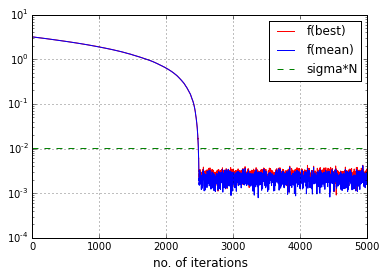

In [ ]:
plt.semilogy(fbest, '-r', label='f(best)')
plt.semilogy(fmean, '-b', label='f(mean)')
plt.semilogy(sigmaN, '--g', label='sigma*N')
plt.xlabel('no. of iterations', fontsize='large')
plt.grid()
plt.legend()

##考察

* init_mean や init_sigma を変えて実験してみよう (適宜maxiterを変更すること)
* 振る舞いを三つの状況(序盤の遅い探索，中盤の速い探索，終盤の停滞)に分けて，それぞれmeanとsigmaがどのような関係にあるのか考えよう
* 中盤の速い探索が続くように，ステップサイズの更新を実装しよう．

In [ ]:
es = ES(func=sphere,            
        init_mean=np.ones(10),  
        init_sigma=0.001,        
        nsample=10)             

maxiter = 100
fbest = np.zeros(maxiter) * np.nan
fmean = np.zeros(maxiter) * np.nan
sigmaN = np.zeros(maxiter) * np.nan
for i in range(fbest.shape[0]):
    es.sample()
    es.evaluate()
    es.update_mean()
    # ステップサイズを更新
    old_sigma = es.sigma
    
    es.sigma = sphere(es.mean) / es.N
    # ここまで
    fbest[i] = es.arf.min()
    fmean[i] = sphere(es.mean)
    sigmaN[i] = es.sigma * es.N